# Visual explainability analysis using IM-SSIM

In this notebook, the heatmaps produced by the FCNNplus and STANDARD_CNN models are analysed using the Structural Similarity Index (SSIM) metric.  
The idea behind the analysis is that if several models, trained on the dataset, highlight the same areas of the image using CAM algorithms, then the discriminating element can be reasonably assumed to be in the highlighted area.  

The IM-SSIM can take values between -1 and 1 where a value of 1 indicates that the two compared images are identical.

## 1. Import main dependecies and defining function

In [1]:
import os 
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
import numpy as np
import cv2

import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model, Model
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm

In [2]:
def ScoreCam(model, img_array, layer_name, max_N=-1):

    cls = np.argmax(model(img_array))
    base_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    act_map_array = base_model(img_array)
    act_map_array = np.asarray(act_map_array)
    
    # extract effective maps
    if max_N != -1:
        act_map_std_list = [np.std(act_map_array[0,:,:,k]) for k in range(act_map_array.shape[3])]
        unsorted_max_indices = np.argpartition(-np.array(act_map_std_list), max_N)[:max_N]
        max_N_indices = unsorted_max_indices[np.argsort(-np.array(act_map_std_list)[unsorted_max_indices])]
        act_map_array = act_map_array[:,:,:,max_N_indices]

    input_shape = model.layers[0].output_shape[0]  # get input shape
    input_shape = (100, 100, 3)
    # 1. upsample to original input size
    act_map_resized_list = [cv2.resize(act_map_array[0,:,:,k], input_shape[:2], interpolation=cv2.INTER_LINEAR) for k in range(act_map_array.shape[3])]
    # 2. normalize the raw activation value in each activation map into [0, 1]
    act_map_normalized_list = []
    for act_map_resized in act_map_resized_list:
        if np.max(act_map_resized) - np.min(act_map_resized) != 0:
            act_map_normalized = act_map_resized / (np.max(act_map_resized) - np.min(act_map_resized))
        else:
            act_map_normalized = act_map_resized
        act_map_normalized_list.append(act_map_normalized)
    # 3. project highlighted area in the activation map to original input space by multiplying the normalized activation map
    masked_input_list = []
    for act_map_normalized in act_map_normalized_list:
        masked_input = np.copy(img_array)
        for k in range(3):
            masked_input[0,:,:,k] *= act_map_normalized
        masked_input_list.append(masked_input)
    masked_input_array = np.concatenate(masked_input_list, axis=0)
    # 4. feed masked inputs into CNN model and softmax
    pred_from_masked_input_array = softmax(model.predict(masked_input_array))
    # 5. define weight as the score of target class
    weights = pred_from_masked_input_array[:,cls]
    # 6. get final class discriminative localization map as linear weighted combination of all activation maps
    cam = np.dot(act_map_array[0,:,:,:], weights)
    cam = np.maximum(0, cam)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0
    
    return cam

def softmax(x):
    f = np.exp(x)/np.sum(np.exp(x), axis = 1, keepdims = True)
    return f

def superimpose(original_img_path, cam, emphasize=False):
    
    img_bgr = cv2.resize(cv2.imread(original_img_path), (100, 100))

    heatmap = cv2.resize(cam, (100, 100))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, 0.5, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

def process_image(image_path):
    
    image = cv2.resize(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB), (100, 100))
    image = np.expand_dims(image, axis=0)
    image = image.reshape(-1, 100, 100, 3).astype('float32')
    
    return image

def compute_imssim(class_path):
    similarity = []
    
    for image in tqdm(os.listdir(class_path)):
    
        image_path = os.path.join(class_path, image)
        t_image = process_image(image_path)
        scorecam_1 = ScoreCam(model_1, t_image, last_conv1)
        scorecam_1 = np.where(scorecam_1 <= 0.5, 0, scorecam_1)
        scorecam_2 = cv2.resize(ScoreCam(model_2, t_image, last_conv2), scorecam_1.shape)
        scorecam_2 = np.where(scorecam_2 <= 0.5, 0, scorecam_2)
        im_ssim = ssim(scorecam_1, scorecam_2)
        similarity.append(im_ssim)
        
    similarity = np.asarray(similarity)
    mean = similarity.mean()
    std = similarity.std()
        
    return mean, std

## 2. Loading test image and models

In [3]:
test_image_path = "test_images/DRUSEN/DRUSEN-1094282-13.jpeg"

# Processing image to shape (1, 100, 100, 3)
image = cv2.cvtColor(cv2.imread(test_image_path), cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (100, 100))
image = np.expand_dims(image, axis=0)
image = image.reshape(-1, 100, 100, 3).astype('float32')

In [4]:
# Loading FCNNplus model
model_1 = load_model('saved_models/FCNNplus/')
last_conv1 = 'conv1d_2'

# Loading STANDARD_CNN model
model_2 = load_model('saved_models/STANDARD_CNN/')
last_conv2 = 'conv2d_2'

## 3. Application of the ScoreCAM algorithm

In [5]:
print('\n[INFO] Creating FCNNplus ScoreCAM')
FCNN_scorecam = ScoreCam(model_1, image, last_conv1)
print('[INFO] Overlapping FCNNplus ScoreCAM')
overlayFCNN = superimpose(test_image_path, FCNN_scorecam)
print('\n[INFO] Creating STANDARD_CNN ScoreCAM')
SCNN_scorecam = ScoreCam(model_2, image, last_conv2)
print('[INFO] Overlapping STANDARD_CNN ScoreCAM\n')
overlaySCNN = superimpose(test_image_path, SCNN_scorecam)


[INFO] Creating FCNNplus ScoreCAM
[INFO] Overlapping FCNNplus ScoreCAM

[INFO] Creating STANDARD_CNN ScoreCAM
[INFO] Overlapping STANDARD_CNN ScoreCAM



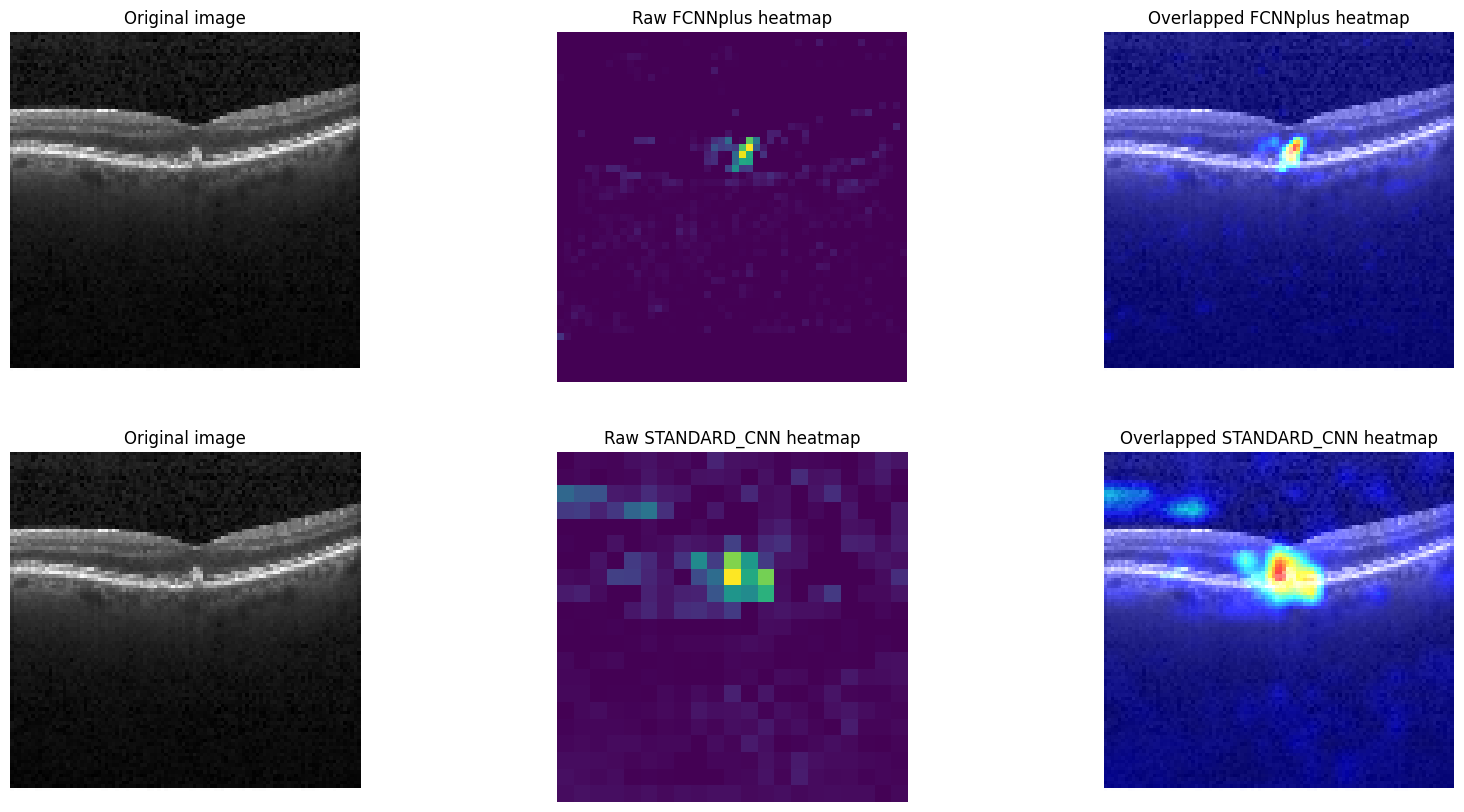

In [6]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.imshow(image[0] / 255)
plt.title('Original image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(FCNN_scorecam)
plt.title('Raw FCNNplus heatmap')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(overlayFCNN)
plt.title('Overlapped FCNNplus heatmap')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(image[0] / 255)
plt.title('Original image')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(SCNN_scorecam)
plt.title('Raw STANDARD_CNN heatmap')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(overlaySCNN)
plt.title('Overlapped STANDARD_CNN heatmap')
plt.axis('off')

plt.show()

## 4. Removal of the least significant areas

Since only the most significant area is to be taken into account, all pixels with a normalised value less than or equal to 0.5 are set to 0.

In [7]:
FCNN_scorecam = np.where(FCNN_scorecam <= 0.5, 0, FCNN_scorecam)
SCNN_scorecam = np.where(SCNN_scorecam <= 0.5, 0 ,SCNN_scorecam)

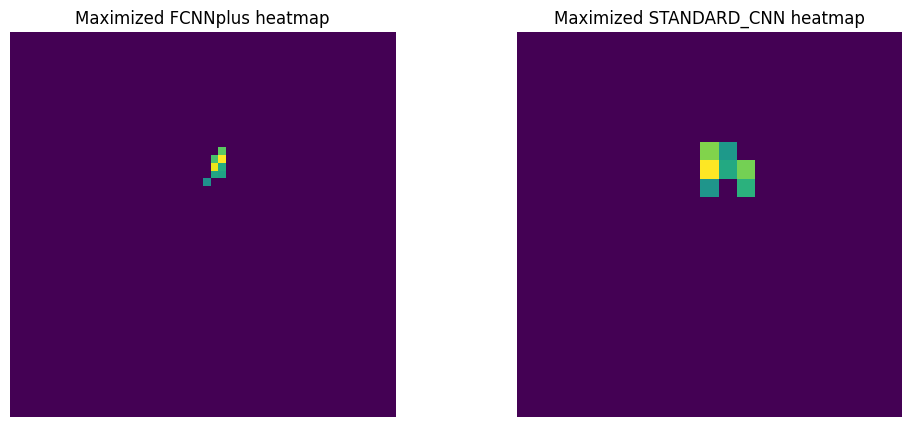

In [8]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.imshow(FCNN_scorecam)
plt.title('Maximized FCNNplus heatmap')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(SCNN_scorecam)
plt.title('Maximized STANDARD_CNN heatmap')
plt.axis('off')

plt.show()

## 5. Process Iteration on the test folder

In [9]:
mean_cnv, std_cnv = compute_imssim("test_images/CNV/")

100%|██████████| 3165/3165 [52:47<00:00,  1.00s/it] 


In [10]:
mean_dme, std_dme = compute_imssim("test_images/DME/")

100%|██████████| 1099/1099 [16:52<00:00,  1.09it/s]


In [13]:
mean_drusen, std_drusen = compute_imssim("test_images/DRUSEN/")

100%|██████████| 783/783 [11:25<00:00,  1.14it/s]


In [19]:
print('[INFO] CNV Class\n')
print('IM-SSIM Mean : {}'.format(round(mean_cnv, 4)))
print('IM-SSIM Standard deviation : {}'.format(round(std_cnv, 4)))

[INFO] CNV Class

IM-SSIM Mean : 0.826
IM-SSIM Standard deviation : 0.0621


In [20]:
print('[INFO] DME Class\n')
print('IM-SSIM Mean : {}'.format(round(mean_dme, 4)))
print('IM-SSIM Standard deviation : {}'.format(round(std_dme, 4)))

[INFO] DME Class

IM-SSIM Mean : 0.8308
IM-SSIM Standard deviation : 0.0756


In [21]:
print('[INFO] DRUSEN Class\n')
print('IM-SSIM Mean : {}'.format(round(mean_drusen, 4)))
print('IM-SSIM Standard deviation : {}'.format(round(std_drusen, 4)))

[INFO] DRUSEN Class

IM-SSIM Mean : 0.8516
IM-SSIM Standard deviation : 0.0678


## 6. Conclusion

From the mean and standard deviation values obtained for the three pathology classes, it can be concluded that the FCNNplus and STANDARD_CNN models do indeed highlight the pathology-related areas, as can be seen from the visual analysis of the heatmaps, but that they are also compatible with each other so that the patterns learnt by the networks are consistent with the clinical diagnosis techniques.  
Of the two models, the FCNNplus network provides more defined and localised heatmaps.